<a href="https://colab.research.google.com/github/imraunav/Computer-vision-EE511/blob/main/LeNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import SGD, Adam
from torch.utils.data import Dataset, DataLoader
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor, Lambda, Compose, Resize
import numpy as np
from tqdm import tqdm
# from tqdm.notebook import tqdm
from torchsummary import summary

In [ ]:
train_dataset = MNIST(root = './',
      train = True,
      transform = Compose([Resize((32, 32)), ToTensor()]),
      target_transform = Lambda(lambda y: torch.zeros(10, dtype=torch.float).scatter_(0, torch.tensor(y), value=1)),
      download = True)
test_dataset = MNIST(root = './',
      train = False,
      transform = Compose([Resize((32, 32)), ToTensor()]),
      target_transform = Lambda(lambda y: torch.zeros(10, dtype=torch.float).scatter_(0, torch.tensor(y), value=1)),
      download = False)

100%|██████████| 9912422/9912422 [00:00<00:00, 29271310.84it/s]


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 72104579.66it/s]


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 28018958.05it/s]


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 16508257.16it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



In [ ]:
train_loader = DataLoader(train_dataset, batch_size = 64, shuffle = True)
test_loader = DataLoader(test_dataset)

In [ ]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print("Using device: ", device)

Using device:  cpu


In [ ]:
class LeNet(nn.Module):
  def __init__(self):
    super().__init__()
    # 1 input image channel, 6 output channels, 5x5 square convolution
    # kernel
    self.conv1 = nn.Conv2d(1, 6, 5)
    self.conv2 = nn.Conv2d(6, 16, 5)
    # an affine operation: y = Wx + b
    self.fc1 = nn.Linear(16 * 5 * 5, 120)  # 5*5 from image dimension
    self.fc2 = nn.Linear(120, 84)
    self.fc3 = nn.Linear(84, 10)
  def forward(self, x):
    # Max pooling over a (2, 2) window
    x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
    # If the size is a square, you can specify with a single number
    x = F.max_pool2d(F.relu(self.conv2(x)), 2)
    x = torch.flatten(x, 1) # flatten all dimensions except the batch dimension
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.fc3(x)
    return x

In [ ]:
model = LeNet().to(device)
summary(model, (1, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 28, 28]             156
            Conv2d-2           [-1, 16, 10, 10]           2,416
            Linear-3                  [-1, 120]          48,120
            Linear-4                   [-1, 84]          10,164
            Linear-5                   [-1, 10]             850
Total params: 61,706
Trainable params: 61,706
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.05
Params size (MB): 0.24
Estimated Total Size (MB): 0.29
----------------------------------------------------------------


In [ ]:
optimizer = Adam(model.parameters())
crit = nn.MSELoss()

In [ ]:
max_epoch = 30
train_loss = []
val_loss = []
# init_patience = 5
# patience = init_patience
# tol = 0.001

for epoch in range(max_epoch):
  print("Epoch:", epoch+1, end=" ")
  model.train()
  running_loss = 0
  nbatch = 0
  for batch in tqdm(train_loader):
    img, target = batch
    img = img.to(device)
    target = target.to(device)
    optimizer.zero_grad()

    pred = model(img)
    loss = crit(pred, target)
    loss.backward()
    optimizer.step()
    running_loss += loss.item()
    nbatch += 1
  train_loss.append(running_loss/nbatch)

  runnging_loss = 0
  nbatch = 0
  for batch in test_loader:
    img, target = batch
    img = img.to(device)
    target = target.to(device)

    pred = model(img)
    loss = crit(pred, target)
    running_loss += loss.item()
    nbatch += 1
  val_loss.append(running_loss/nbatch)
  print(f"Train loss: {train_loss[-1]:.5f}, Val loss: {val_loss[-1]:.5f}")
  # if epoch < 20:
  #   continue
  # if abs(val_loss[-2] - val_loss[-1]) < tol:
  #   patience -= 1
  # else:
  #   patience = init_patience
  # if patience == 0:
  #   print("Early stopping")
  #   break


Epoch: 1 

100%|██████████| 938/938 [00:32<00:00, 28.70it/s]


Train loss: 0.01459, Val loss: 0.00611
Epoch: 2 

100%|██████████| 938/938 [00:32<00:00, 29.15it/s]


Train loss: 0.00398, Val loss: 0.00357
Epoch: 3 

100%|██████████| 938/938 [00:32<00:00, 28.97it/s]


Train loss: 0.00279, Val loss: 0.00277
Epoch: 4 

100%|██████████| 938/938 [00:32<00:00, 28.61it/s]


Train loss: 0.00218, Val loss: 0.00224
Epoch: 5 

100%|██████████| 938/938 [00:33<00:00, 28.05it/s]


Train loss: 0.00179, Val loss: 0.00220
Epoch: 6 

100%|██████████| 938/938 [00:33<00:00, 27.98it/s]


Train loss: 0.00154, Val loss: 0.00196
Epoch: 7 

100%|██████████| 938/938 [00:32<00:00, 28.79it/s]


Train loss: 0.00132, Val loss: 0.00186
Epoch: 8 

100%|██████████| 938/938 [00:32<00:00, 29.16it/s]


Train loss: 0.00116, Val loss: 0.00173
Epoch: 9 

100%|██████████| 938/938 [00:32<00:00, 29.22it/s]


Train loss: 0.00100, Val loss: 0.00162
Epoch: 10 

100%|██████████| 938/938 [00:32<00:00, 29.25it/s]


Train loss: 0.00088, Val loss: 0.00170
Epoch: 11 

100%|██████████| 938/938 [00:32<00:00, 29.20it/s]


Train loss: 0.00081, Val loss: 0.00151
Epoch: 12 

100%|██████████| 938/938 [00:32<00:00, 28.95it/s]


Train loss: 0.00069, Val loss: 0.00141
Epoch: 13 

100%|██████████| 938/938 [00:32<00:00, 29.08it/s]


Train loss: 0.00060, Val loss: 0.00156
Epoch: 14 

100%|██████████| 938/938 [00:32<00:00, 28.44it/s]


Train loss: 0.00058, Val loss: 0.00159
Epoch: 15 

100%|██████████| 938/938 [00:33<00:00, 27.91it/s]


Train loss: 0.00052, Val loss: 0.00161
Epoch: 16 

100%|██████████| 938/938 [00:32<00:00, 28.45it/s]


Train loss: 0.00049, Val loss: 0.00144
Epoch: 17 

100%|██████████| 938/938 [00:32<00:00, 29.05it/s]


Train loss: 0.00043, Val loss: 0.00144
Epoch: 18 

100%|██████████| 938/938 [00:32<00:00, 29.31it/s]


Train loss: 0.00038, Val loss: 0.00142
Epoch: 19 

100%|██████████| 938/938 [00:32<00:00, 29.19it/s]


Train loss: 0.00042, Val loss: 0.00145
Epoch: 20 

100%|██████████| 938/938 [00:32<00:00, 29.10it/s]


Train loss: 0.00037, Val loss: 0.00158
Epoch: 21 

100%|██████████| 938/938 [00:32<00:00, 29.27it/s]


Train loss: 0.00031, Val loss: 0.00148
Epoch: 22 

100%|██████████| 938/938 [00:32<00:00, 29.28it/s]


Train loss: 0.00033, Val loss: 0.00161
Epoch: 23 

100%|██████████| 938/938 [00:32<00:00, 29.09it/s]


Train loss: 0.00036, Val loss: 0.00144
Epoch: 24 

100%|██████████| 938/938 [00:32<00:00, 28.48it/s]


Train loss: 0.00023, Val loss: 0.00136
Epoch: 25 

100%|██████████| 938/938 [00:33<00:00, 27.78it/s]


Train loss: 0.00027, Val loss: 0.00165
Epoch: 26 

100%|██████████| 938/938 [00:32<00:00, 28.73it/s]


Train loss: 0.00029, Val loss: 0.00159
Epoch: 27 

100%|██████████| 938/938 [00:32<00:00, 29.26it/s]


Train loss: 0.00025, Val loss: 0.00161
Epoch: 28 

100%|██████████| 938/938 [00:32<00:00, 29.20it/s]


Train loss: 0.00022, Val loss: 0.00131
Epoch: 29 

100%|██████████| 938/938 [00:32<00:00, 28.91it/s]


Train loss: 0.00018, Val loss: 0.00136
Epoch: 30 

100%|██████████| 938/938 [00:32<00:00, 28.97it/s]


Train loss: 0.00025, Val loss: 0.00148


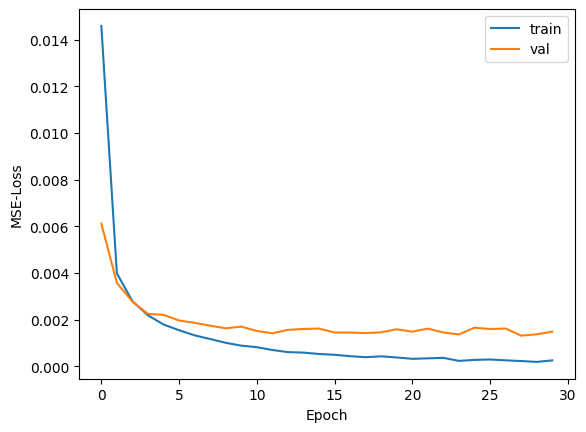

In [ ]:
from matplotlib import pyplot as plt

plt.plot(train_loss)
plt.plot(val_loss)
plt.legend(['train', 'val'])
plt.xlabel('Epoch')
plt.ylabel('MSE-Loss')
plt.show()